# Finite Difference in 2D

1. Finite Difference solver for the 2D Poisson problem:

$-\Delta u=f \quad \in \Omega=(a,b)^2$

$u|_{\partial\Omega}=0$

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve

Function computing the 2D FD algebric system

In [27]:
omega = [0, 1]
N = 3

h = (omega[1]-omega[0])/N
x = np.linspace(omega[0],omega[1],N+1)
y = x
# 2-dim grid
X, Y = np.meshgrid(x,y)

X = X.flatten()
Y = Y.flatten()

print(X)

print(Y)

[0.         0.33333333 0.66666667 1.         0.         0.33333333
 0.66666667 1.         0.         0.33333333 0.66666667 1.
 0.         0.33333333 0.66666667 1.        ]
[0.         0.         0.         0.         0.33333333 0.33333333
 0.33333333 0.33333333 0.66666667 0.66666667 0.66666667 0.66666667
 1.         1.         1.         1.        ]


In [28]:
def FD2D(omega,N,rhs):
  # FD system matrix and rhs in omega^2 for
  # poisson equation homogeneous Dirichlet bc
  # uniform grid in sparse CSR format
  # with Nx = Ny = N

  # x and y axis grid
  h = (omega[1]-omega[0])/N
  x = np.linspace(omega[0],omega[1],N+1)
  y = x
  # 2-dim grid
  X, Y = np.meshgrid(x,y)
  X = X.flatten()
  Y = Y.flatten()

  # compute rhs
  F = rhs(X,Y)

  # compute system matrix
  # -(1/h^2) (U_{i,j-1}  +U_{i-1,j})     - 4 * U_{i,j}  +   U_{i+1,j} + U_{i,j+1} )
  coefs = [-1*np.ones((N+1)*(N)) ,-1*np.ones((N+1)*(N+1)-1),4*np.ones((N+1)*(N+1)),-1*np.ones((N+1)*(N+1)-1),-1*np.ones((N+1)*(N))]
  A = sp.diags(coefs, [-(N+1), -1, 0, 1, N+1],format="csr")

  # Implement boundary conditions
  for i in range(N+1):
    # y = a
    A[i,A[i].nonzero()] = 0; A[i,i] = 1; F[i] = 0
    # y = b
    j = (N+1) * N + i
    A[j,A[j].nonzero()] = 0; A[j,j] = 1; F[j] = 0

  for i in range(1,N):
    # x = a
    j = i * (N+1)
    A[j,A[j].nonzero()] = 0; A[j,j] = 1; F[j] = 0
    # x = b
    j = i * (N+1) + N
    A[j,A[j].nonzero()] = 0; A[j,j] = 1; F[j] = 0

  return (1./h**2) * A, F

Define FD problem and solve with $(a,b)=(0,
pi)$ and

$u(x,y)=sin(x)*sin(y)$

hence

$f=2* sin(x)*sin(y)$

In [29]:
# Problem data
omega = [0, np.pi]
N=50
rhs = lambda x, y : 2 * np.sin(x) * np.sin(y)
u = lambda x, y : np.sin(x) * np.sin(y)

# call function computing FD system
A, F = FD2D(omega,N,rhs)

# solve
uh = spsolve(A,F)


Plot solution

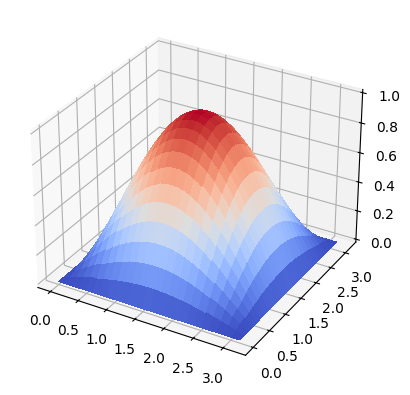

In [30]:
# Prepare data for plotting
x = np.linspace(omega[0],omega[1],N+1)
y = x
# 2-dim grid
X, Y = np.meshgrid(x,y)
Uh = uh.reshape((N+1),(N+1))

# Plot the solution
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, Uh, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

plt.show()

Compute discrete max norm error

In [31]:
# compute exact sol
U = u(X,Y)



# Print discrete error
print(np.max(np.max(np.abs(U-Uh))))

0.00032905176292330474


**Exercise 1**: Run a series of experiments each time halfing the mesh size to each time computing the error and the EOC

In [32]:
# Number of experiments
n_exp = 7

# Problem data
omega = [0, np.pi]
rhs = lambda x, y : 2 * np.sin(x) * np.sin(y)
u = lambda x, y : np.sin(x) * np.sin(y)

# Initial grid size
N = 320

# Call function computing FD system
A, F = FD2D(omega,N,rhs)

# Solve
uh = spsolve(A,F)
Uh = uh.reshape((N+1),(N+1))

x = np.linspace(omega[0],omega[1],N+1)
y = x
# 2-dim grid
X, Y = np.meshgrid(x,y)

# Compute exact solution
U = u(X,Y)

# Compute error
err = np.max(np.max(np.abs(U-Uh)))
h = (omega[1]-omega[0])/N
print("h = ",h, "N = ",N, "err = ",err)

# Loop over experiments
for i in range(n_exp-1):
    # Half the mesh size
    N = N // 2
    x = np.linspace(omega[0],omega[1],N+1)
    y = x
    X, Y = np.meshgrid(x,y)

    # Call function computing FD system
    A, F = FD2D(omega,N,rhs)
    
    # Solve
    uh_1 = spsolve(A,F)
    Uh_1 = uh_1.reshape((N+1),(N+1))
    
    # Compute exact solution
    U = u(X,Y)
    
    # Compute error
    err_1 = np.max(np.max(np.abs(U-Uh_1)))
    h_1 = (omega[1]-omega[0])/N
    print("h = ",h_1, "N = ",N, "err = ",err_1)
    
    # Compute EOC
    eoc = (np.log(err) - np.log(err_1)) / (np.log(h) - np.log(h_1))
    print("EOC = ",eoc)
    
    # Update error and mesh size
    err = err_1
    h = h_1


h =  0.009817477042468103 N =  320 err =  8.031942997810404e-06
h =  0.019634954084936207 N =  160 err =  3.2128237739792453e-05
EOC =  2.0000209142499665
h =  0.039269908169872414 N =  80 err =  0.00012852038352351158
EOC =  2.0000834360550264
h =  0.07853981633974483 N =  40 err =  0.000514200478143767
EOC =  2.0003337605625666
h =  0.15707963267948966 N =  20 err =  0.0020587067645327917
EOC =  2.0013354950189095
h =  0.3141592653589793 N =  10 err =  0.008265416966227512
EOC =  2.005349249284653
h =  0.6283185307179586 N =  5 err =  0.03035384990433254
EOC =  1.876720004833911


**Exercise 2**: Generalise the FD2D routine to assemble more general elliptic problems. For instance, solve

-$\alpha \Delta u + {\bf b}\cdot \nabla u + c u =f\, $ in $\, \Omega$,

with homogeneous Dirichlet and nonhomogeneous Dirichlet boundary conditions.

Write a program to test your routine and check EOC.

In [33]:
def FD2D(omega,N,rhs,alpha=1.0,b=[0,0],c=0.0,dirichlet_bc=[0,0]):
  # FD system matrix and rhs in omega^2 for
  # general elliptic problem with homogeneous Dirichlet or non-homogeneus Dirichlet bc
  # uniform grid in sparse CSR format
  # with Nx = Ny = N

  # x and y axis grid
  h = (omega[1]-omega[0])/N
  x = np.linspace(omega[0],omega[1],N+1)
  y = x
  # 2-dim grid
  X, Y = np.meshgrid(x,y)
  X = X.flatten()
  Y = Y.flatten()
  
  # Boundary conditions
  ur = dirichlet_bc[1]
  ul = dirichlet_bc[0]

  # Define coefficients
  laplace_coef = -alpha / h**2
  conv_x_coef = b[0] / (2 * h)
  conv_y_coef = b[1] / (2 * h)
  
  # compute rhs
  F = rhs(X,Y)

  # compute system matrix
  # (Laplacian term and reaction term)
  A_diag = -4 * laplace_coef * np.ones((N+1)**2) + c * np.ones((N+1)**2)
  A_left = laplace_coef * np.ones((N+1) * N)
  A_right = laplace_coef * np.ones((N+1) * N)
  A_up = laplace_coef * np.ones((N+1) * (N+1) - 1)
  A_down = laplace_coef * np.ones((N+1) * (N+1) - 1)
  # (Convection term)
  A_conv_left = -conv_x_coef * np.ones((N+1) * N)
  A_conv_right = conv_x_coef * np.ones((N+1) * N)
  A_conv_up = conv_y_coef * np.ones((N+1) * (N+1) - 1)
  A_conv_down = -conv_y_coef * np.ones((N+1) * (N+1) - 1)
  # Assemble matrix
  A = sp.diags([A_left + A_conv_left, A_down + A_conv_down, 
                  A_diag, A_up + A_conv_up, A_right + A_conv_right], 
                 [-(N+1), -1, 0, 1, N+1], format="csr")
  
  

  # Implement boundary conditions
  for i in range(N+1):
    # y = a (bottom)
    A[i,A[i].nonzero()] = 0; A[i,i] = 1
    F[i] = ul
    # y = b (top)
    j = (N+1) * N + i
    A[j,A[j].nonzero()] = 0; A[j,j] = 1
    F[j] = ur

  for i in range(1,N):
    # x = a (left)
    j = i * (N+1)
    A[j,A[j].nonzero()] = 0; A[j,j] = 1
    F[j] = ul
    # x = b (right)
    j = i * (N+1) + N
    A[j,A[j].nonzero()] = 0; A[j,j] = 1
    F[j] = ur

  return A, F

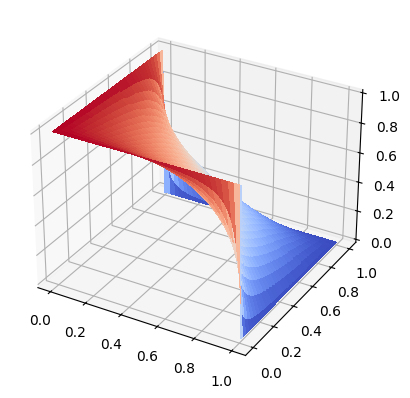

In [39]:
# Problem data
omega = [0, 1]
N=100
rhs = lambda x, y : np.zeros_like(x)
alpha = 1.0
b = [1, 1]
c = 1
dirichlet_bc = [1, 0]

# Call function computing FD system
A, F = FD2D(omega,N,rhs,alpha,b,c,dirichlet_bc)

# Solve
uh = spsolve(A,F)

# Prepare data for plotting
x = np.linspace(omega[0],omega[1],N+1)
y = x
# 2-dim grid
X, Y = np.meshgrid(x,y)
Uh = uh.reshape((N+1),(N+1))

# Plot the solution
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, Uh, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

plt.show()

In [ ]:
# Problem data (simplify some terms for the exact solution)
omega = [0, np.pi]
rhs = lambda x, y : 2 * np.sin(x) * np.sin(y)
alpha = 1.0
b = [0, 0]
c = 0.0

# Exact solution
u = lambda x, y : np.sin(x) * np.sin(y)

## Number of experiments
n_exp = 6

# Initial grid size
N = 320

# Call function computing FD system
A, F = FD2D(omega,N,rhs,alpha,b,c)

# Solve
uh = spsolve(A,F)
Uh = uh.reshape((N+1),(N+1))

x = np.linspace(omega[0],omega[1],N+1)
y = x
# 2-dim grid
X, Y = np.meshgrid(x,y)

# Compute exact solution
U = u(X,Y)

# Compute error
err = np.max(np.max(np.abs(U-Uh)))
h = (omega[1]-omega[0])/N

# Loop over experiments
for i in range(n_exp-1):
    # Half the mesh size
    N = N // 2
    x = np.linspace(omega[0],omega[1],N+1)
    y = x
    X, Y = np.meshgrid(x,y)

    # Call function computing FD system
    A, F = FD2D(omega,N,rhs)
    
    # Solve
    uh_1 = spsolve(A,F)
    Uh_1 = uh_1.reshape((N+1),(N+1))
    
    # Compute exact solution
    U = u(X,Y)
    
    # Compute error
    err_1 = np.max(np.max(np.abs(U-Uh_1)))
    h_1 = (omega[1]-omega[0])/N
    
    # Compute EOC
    eoc = (np.log(err) - np.log(err_1)) / (np.log(h) - np.log(h_1))
    print("EOC = ",eoc, "with N = ",N)
    
    # Update error and mesh size
    err = err_1
    h = h_1


EOC =  2.0000209142499665 with N =  160
EOC =  2.0000834360550264 with N =  80
EOC =  2.0003337605625666 with N =  40
EOC =  2.0013354950189095 with N =  20
EOC =  2.005349249284653 with N =  10
